# Cals lstm seqtoseq test
Use a lstm seq to seq tensorflow model to train a network to predict time series outputs.

In [1]:
import tensorflow as tf
import numpy as np 
import random
import math
from matplotlib import pyplot as plt
import os
import copy
import pandas as pd
from pandas import Series
import random
from sklearn import preprocessing

import ipdb
#import pixiedust

(39244, 1)
39244
392.44
[0.0000e+00 1.0000e-02 2.0000e-02 ... 3.9241e+02 3.9242e+02 3.9243e+02]


Text(0, 0.5, 'newData')

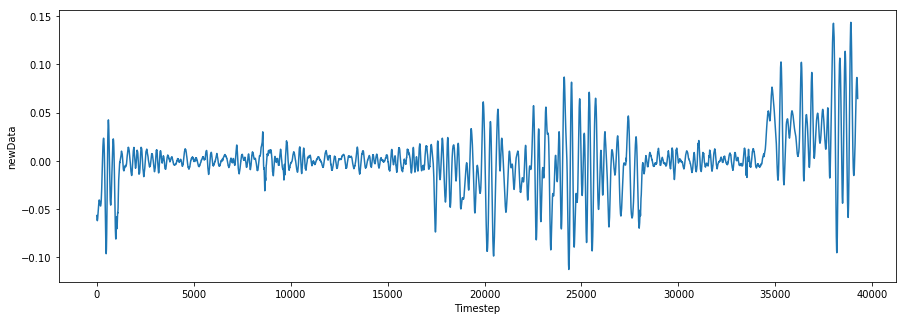

In [36]:
## The test data
newData = pd.read_csv(r'./test_data/pitch_sen_data.txt', delimiter=',')
print(newData.shape)

newData = np.squeeze(newData.to_numpy()) # COnvert to numpy array remove 1 length dimensions
tdata_len = len(newData)

step_period = 0.01 # data is taken at 100 Hz
max_time = tdata_len * step_period 
print(tdata_len)
print(max_time)
min_time = 0
newDataTime = np.arange(min_time,max_time, step_period)
print(newDataTime)

plt.figure(figsize=(15,5))

plt.plot(newData)
plt.xlabel("Timestep")
plt.ylabel("newData")

In [6]:
# normalise the data 
series = Series(newData)
print("Orig input data %s \n" % series.values)
# prepare data for normalization
values = series.values
values = values.reshape((len(values), 1))
# train the normalization
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)
print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
# normalize the dataset and print
normalized = scaler.transform(values)
print("Normalised data %s \n" % normalized)
# inverse transform and print
inversed = scaler.inverse_transform(normalized)
print("inversed normalised data (orig) \n %s" % inversed)

Orig input data [-0.0567 -0.0571 -0.0573 ...  0.0667  0.0657  0.0646] 

Min: -0.112500, Max: 0.143400
Normalised data [[0.21805393]
 [0.21649082]
 [0.21570926]
 ...
 [0.70027354]
 [0.69636577]
 [0.69206721]] 

inversed normalised data (orig) 
 [[-0.0567]
 [-0.0571]
 [-0.0573]
 ...
 [ 0.0667]
 [ 0.0657]
 [ 0.0646]]


In [7]:

in_seq_len = 60
out_seq_len = 30
noise_factor = 0.0

x = np.linspace(0, max_time, tdata_len)

def true_signal(x, y_data):
    
    y = y_data[x]
    return y

def noise_func(x, noise_factor = 1):
    return np.random.randn(len(x)) * noise_factor

def generate_y_values(x, y_data, noise_factor = 1):
    # For each array in x generate a corresponding output array y from the y_data array input.
    return true_signal(x, y_data) + noise_func(x, noise_factor)


def generate_train_samples(input_y, batch_size = 10, 
                           input_seq_len = in_seq_len, output_seq_len = out_seq_len):
    # input_y is an array e.g the data to learn
    
    # create an index array
    input_x = np.arange(0,len(input_y))
    assert len(input_x) == len(input_y)
    
    total_start_points = len(input_x) - input_seq_len - output_seq_len
    #print("total_start_points = ", total_start_points)
    start_x_idx = np.random.choice(range(total_start_points), batch_size)
    #print("start_x_idx = \n", start_x_idx)
    
    input_seq_x = [input_x[i:(i+input_seq_len)] for i in start_x_idx]
    output_seq_x = [input_x[(i+input_seq_len):(i+input_seq_len+output_seq_len)] for i in start_x_idx]
    #print("input_seq_x = \n", input_seq_x)
    #print("output_seq_x = \n", output_seq_x)
    
    #ipdb.set_trace()
    input_seq_y = [generate_y_values(x, input_y, noise_factor) for x in input_seq_x]
    output_seq_y = [generate_y_values(x, input_y, noise_factor) for x in output_seq_x]
    
    #batch_x = np.array([[true_signal()]])
    return np.array(input_seq_y), np.array(output_seq_y)


[[0.21805393]
 [0.21649082]
 [0.21570926]
 ...
 [0.70027354]
 [0.69636577]
 [0.69206721]]
[0.21805393 0.21649082 0.21570926 ... 0.70027354 0.69636577 0.69206721]


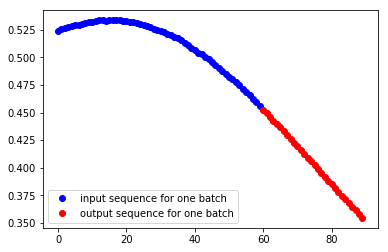

In [10]:
print(normalized)
testData = normalized.flatten()
print(testData)
input_seq, output_seq = generate_train_samples(testData, batch_size=10)

l1, = plt.plot(range(in_seq_len), input_seq[1], 'bo', label = 'input sequence for one batch')
plt_start = in_seq_len
plt_end = in_seq_len + out_seq_len
l2, = plt.plot(range(plt_start, plt_end), output_seq[1], 'ro', label = 'output sequence for one batch')
plt.legend(handles = [l1, l2], loc = 'lower left')
plt.show()

## basic_rnn_seq2seq

In [50]:
from build_model_basic import * 

## Parameters
learning_rate = 0.0025
lambda_l2_reg = 0.003  

## Network Parameters
# length of input signals
input_seq_len =120 
# length of output signals
output_seq_len = 20 
# size of LSTM Cell
hidden_dim = 64 
# num of input signals
input_dim = 1
# num of output signals
output_dim = 1
# num of stacked lstm layers 
num_stacked_layers = 2 
# gradient clipping - to avoid gradient exploding
GRADIENT_CLIPPING = 2.5 

In [51]:
total_iteractions = 3000
batch_size = 16
KEEP_RATE = 0.5
train_losses = []
val_losses = []

rnn_model = build_graph(feed_previous=False, input_seq_len=input_seq_len, output_seq_len = output_seq_len,  
                        hidden_dim = hidden_dim, input_dim = input_dim, output_dim = output_dim,
                        num_stacked_layers = num_stacked_layers, GRADIENT_CLIPPING = GRADIENT_CLIPPING,
                        learning_rate=learning_rate, lambda_l2_reg=lambda_l2_reg)

saver = tf.train.Saver()

init = tf.global_variables_initializer()
losses = []
with tf.Session() as sess:

    sess.run(init)
    
    for i in range(total_iteractions):
        batch_input, batch_output = generate_train_samples(testData, 
                                                           batch_size=batch_size, 
                                                           input_seq_len=input_seq_len, 
                                                           output_seq_len=output_seq_len)
        #print(batch_input[:,1].reshape(-1,input_dim))
        
        feed_dict = {rnn_model['enc_inp'][t]: batch_input[:,t].reshape(-1,input_dim) for t in range(input_seq_len)}
        feed_dict.update({rnn_model['target_seq'][t]: batch_output[:,t].reshape(-1,output_dim) for t in range(output_seq_len)})
        _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
        losses.append(loss_t)
        if i % 100 == 0:
            print("training index = %s, loss = %s" %(i, loss_t))
        
    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, os.path.join('./', 'univariate_ts_model0'))
        
print("Checkpoint saved at: ", save_path)
    


training index = 0, loss = 3.5967216
training index = 100, loss = 0.06424677
training index = 200, loss = 0.049351554
training index = 300, loss = 0.035516754
training index = 400, loss = 0.02678999
training index = 500, loss = 0.021949355
training index = 600, loss = 0.01813117
training index = 700, loss = 0.013564792
training index = 800, loss = 0.011163861
training index = 900, loss = 0.009938204
training index = 1000, loss = 0.007957974
training index = 1100, loss = 0.0064616636
training index = 1200, loss = 0.0064503164
training index = 1300, loss = 0.0049353857
training index = 1400, loss = 0.004305794
training index = 1500, loss = 0.0040449435
training index = 1600, loss = 0.0034062755
training index = 1700, loss = 0.006413701
training index = 1800, loss = 0.002753457
training index = 1900, loss = 0.0032413024
training index = 2000, loss = 0.00281385
training index = 2100, loss = 0.0026600258
training index = 2200, loss = 0.0020488184
training index = 2300, loss = 0.0019120324
t

Text(0, 0.5, 'Loss')

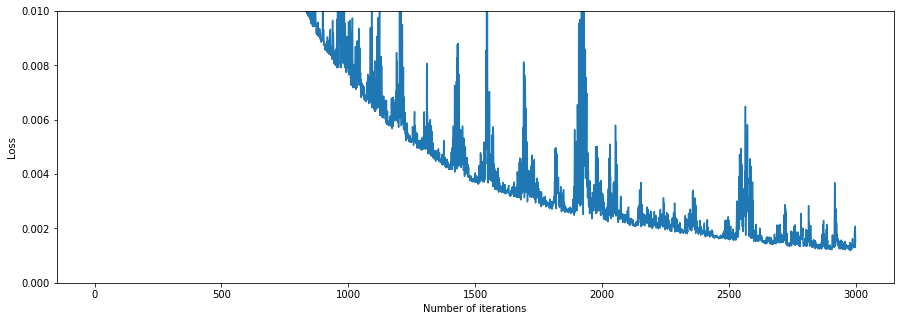

In [52]:
plt.figure(figsize=(15,5))
plt.ylim(top=0.01) # limit the yaxis maximum value
plt.plot(losses)
plt.xlabel("Number of iterations")
plt.ylabel("Loss")

## Inference

INFO:tensorflow:Restoring parameters from ./univariate_ts_model0


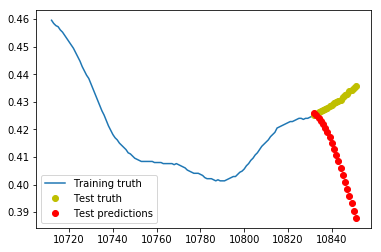

INFO:tensorflow:Restoring parameters from ./univariate_ts_model0


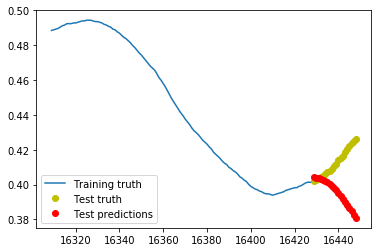

INFO:tensorflow:Restoring parameters from ./univariate_ts_model0


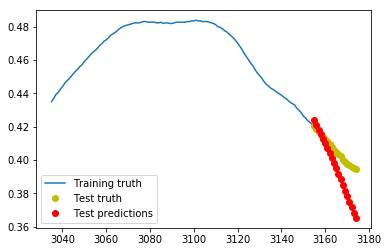

INFO:tensorflow:Restoring parameters from ./univariate_ts_model0


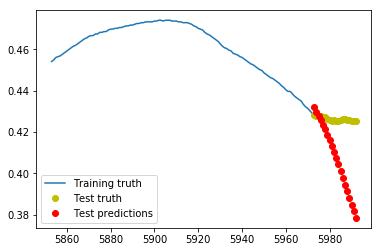

INFO:tensorflow:Restoring parameters from ./univariate_ts_model0


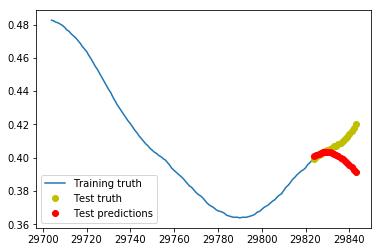

In [53]:
#print(train_data_x)
num_predictions = 5

for i in range(num_predictions):
    len_inf_data = input_seq_len
    start_ind = random.randint(0, len(testData) - output_seq_len)
    end_ind = start_ind + len_inf_data
    test_ind = np.arange(start_ind, end_ind)

    test_seq_input = true_signal(test_ind, testData)

    rnn_model = build_graph(feed_previous=True,input_seq_len=input_seq_len, output_seq_len = output_seq_len,  
                        hidden_dim = hidden_dim, input_dim = input_dim, output_dim = output_dim,
                        num_stacked_layers = num_stacked_layers, GRADIENT_CLIPPING = GRADIENT_CLIPPING,
                        learning_rate=learning_rate, lambda_l2_reg=lambda_l2_reg)
    
#     print(test_seq_input)
#     print(input_seq_len)
#     print(len(rnn_model['enc_inp']))

    init = tf.global_variables_initializer()
    with tf.Session() as sess:

        sess.run(init)

        saver = rnn_model['saver']().restore(sess, os.path.join('./', 'univariate_ts_model0'))

        feed_dict = {rnn_model['enc_inp'][t]: test_seq_input[t].reshape(1,1) for t in range(input_seq_len)}
        feed_dict.update({rnn_model['target_seq'][t]: np.zeros([1, output_dim]) for t in range(output_seq_len)})
        final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)

        final_preds = np.concatenate(final_preds, axis = 1)

    # Plot the last 20 predictions
    l1, = plt.plot(test_ind, true_signal(test_ind, testData), label = 'Training truth')
    out_ind = range(end_ind, end_ind+output_seq_len)
    l2, = plt.plot(out_ind, testData[out_ind], 'yo', label = 'Test truth')
    l3, = plt.plot(out_ind, final_preds.reshape(-1), 'ro', label = 'Test predictions')
    plt.legend(handles = [l1, l2, l3], loc = 'lower left')
    plt.show()

# Multivariant 

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns

df = pd.read_csv('./tst_data/dacs_data_Op08_log.csv')
print(df.head())

cols_to_plot = ["pm2.5", "DEWP", "TEMP", "PRES", "Iws", "Is", "Ir"]
i = 1
# plot each column
plt.figure(figsize = (10,12))
for col in cols_to_plot:
    plt.subplot(len(cols_to_plot), 1, i)
    plt.plot(df[col])
    plt.title(col, y=0.5, loc='left')
    i += 1
plt.show()

ModuleNotFoundError: No module named 'seaborn'